In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
%matplotlib inline

In [8]:
# This loads the pots data and then Procrustes aligns them and scales them into [-1,1].
# There are four extra pieces of information about each pot that are in the last two pairs of points.
from scipy.spatial import procrustes

#pots = np.loadtxt('FinalDatasetPoints.txt')

npoints = np.shape(pots)[0]-2
npots = np.shape(pots)[1]//2

pots = pots.reshape([npoints+2,npots,2])
pots = pots.transpose([1,0,2])

indices = np.copy(pots[:,-2:,:])

pots = pots[:,:-2,:]

newpots = np.zeros(np.shape(pots))
for j in range(npots):
    mtx1, newpots[j,:,:], _ = procrustes(pots[0,:,:],pots[j,:,:])
#newpots[0,:,:] = mtx1
newpots/=np.max(newpots)
pl.plot(pots[0,:-2,0],pots[0,:-2,1])

(716, 276)


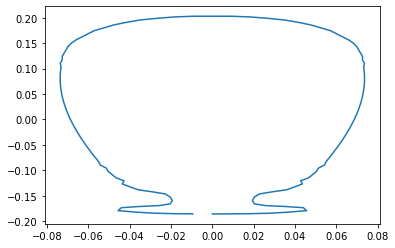

In [17]:
pots = np.genfromtxt('../../AllPots/Data/Pots/NewSample_UnitLength_Procrustes.csv', delimiter=',')
npots = np.shape(pots)[0]
npoints = np.shape(pots)[1]//2
pl.plot(pots[0,::2],pots[0,1::2])
print(np.shape(pots))

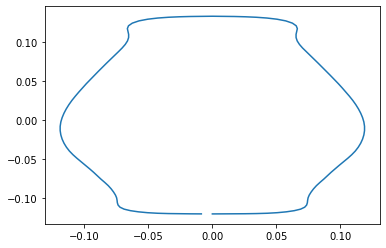

In [18]:
# Perform PCA
#pots = newpots.reshape([npots,npoints*2])
C = np.cov(pots.T)

# Get the eigenvalues and eigenvectors
evals,evecs = np.linalg.eig(C)

# Now need to sort them into descending order
indices = np.argsort(evals)
indices = indices[::-1]
evecs = evecs[:,indices]
evals = evals[indices]
evecs = np.real(evecs)
evals = np.real(evals)
m = np.mean(pots,axis=0).reshape((npoints,2))
#evecs = evecs.reshape((npoints,2,npoints*2))
#pl.plot(m[:,0],m[:,1])


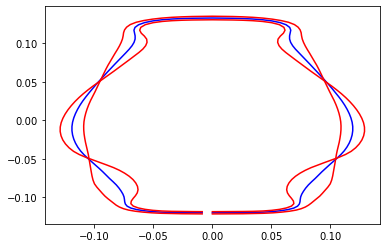

In [19]:
# Plot a principal component
evecs2 = evecs.reshape((npoints,2,npoints*2))
sd = 1
pc = 2
pl.plot(m[:,0],m[:,1],'b')
pl.plot(m[:,0] - np.sqrt(evals[pc])*sd*evecs2[:,0,pc],m[:,1] - np.sqrt(evals[pc])*sd*evecs2[:,1,pc],'r') 
pl.plot(m[:,0] + np.sqrt(evals[pc])*sd*evecs2[:,0,pc],m[:,1] + np.sqrt(evals[pc])*sd*evecs2[:,1,pc],'r') 


Number of dims to use: 6


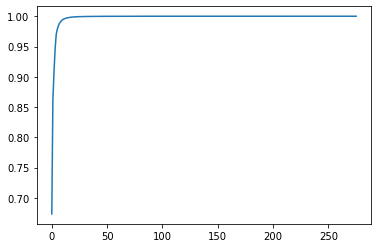

In [20]:
# Scree plot of the cumulative sum of variances
cs = np.cumsum(evals)
cs /= cs[-1]
pl.plot(cs)
varToSave = 0.98
print("Number of dims to use:",np.where(cs>varToSave*cs[-1])[0][0])
#print(cs[:10])
#print(np.shape(C),np.shape(evecs),np.shape(evals))

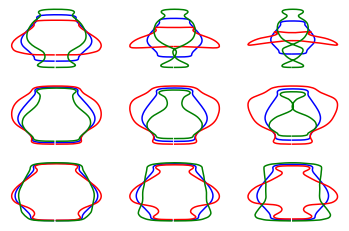

In [21]:
# Plot of the first three principal components
for pc in range(3):
    for sd in range(1,4):
        pl.subplot(3,3,pc*3+sd);
        pl.plot(m[:,0],m[:,1],'b')
        pl.plot(m[:,0] - np.sqrt(evals[pc])*sd*evecs2[:,0,pc],m[:,1] - np.sqrt(evals[pc])*sd*evecs2[:,1,pc],'r') 
        pl.plot(m[:,0] + np.sqrt(evals[pc])*sd*evecs2[:,0,pc],m[:,1] + np.sqrt(evals[pc])*sd*evecs2[:,1,pc],'g')         
        pl.axis('off')

In [22]:
# 10D embedding of the pots
# This is mostly the code you want -- the b variable holds the principal component representation
ndim = 10
m = np.mean(pots,axis=0)
b = np.zeros((npots,ndim))
for i in range(npots):
    P = evecs[:,:ndim]
    b[i,:] = np.dot(P.T,(pots[i,:]-m))

#np.savetxt('AthenianBFRF_eigenshape_embedding_10D.csv',b)

In [60]:
# L2 (SSD) distances between the whole set of pots
dists = np.zeros((npots,npots))
for i in range(npots):
    for j in range(i,npots):
        dists[i,j] = np.linalg.norm(b[i,:]-b[j,])
np.savetxt('EigenshapeDists.csv',dists)

In [41]:
# Plot according to PCA locations in 2D

# This sets up the colours for PCA plotting
ind = np.loadtxt('/home/marslast/Projects/AllPots/Code/pots_list.txt')
cl = np.unique(ind[:,1]).astype(int)
print(cl)
import matplotlib.colors as plc
cmap = pl.cm.get_cmap('inferno')
cnorm = plc.Normalize(vmin=0.0,vmax=len(cl))
colours = {}

count = 0
for i in cl:
    colours[i] = cmap((cnorm(count)))
    count += 1

def meanshape(pots):
    means = np.zeros((24,npoints*2))
    for i in range(len(cl)):
        which = np.where(ind[:,1]==cl[i])
        means[i,:] = np.mean(pots[which,:],axis=1)
    return means

def plotpca(pca,pots,x,y,scaling=None,shift=None):
    means = meanshape(pots)
    pl.figure(figsize=(20,20));
    if scaling is None:
        scaling=1
    #print(scaling)
    if shift is None:
        shift = np.array([0,0])
    for i, (pr, x, y) in enumerate(zip(pca, x,y)):
         pl.plot(pr[0],pr[1],'.',color=colours[int(ind[i,1])],markersize=10);
    for i in range(len(cl)):
        which = np.where(ind[:,1]==cl[i])
        mean = np.squeeze(np.median(pca[which,:],axis=1))
        pl.plot(mean[0]+ means[i,::2]/scaling,mean[1] + means[i,1::2]/scaling,color=colours[cl[i]],linewidth=3);
                        
        #pl.text(-pr[0]+shift[0],pr[1]+shift[1],i, bbox={'facecolor':'white', 'edgecolor': 'white', 'alpha':.5});


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


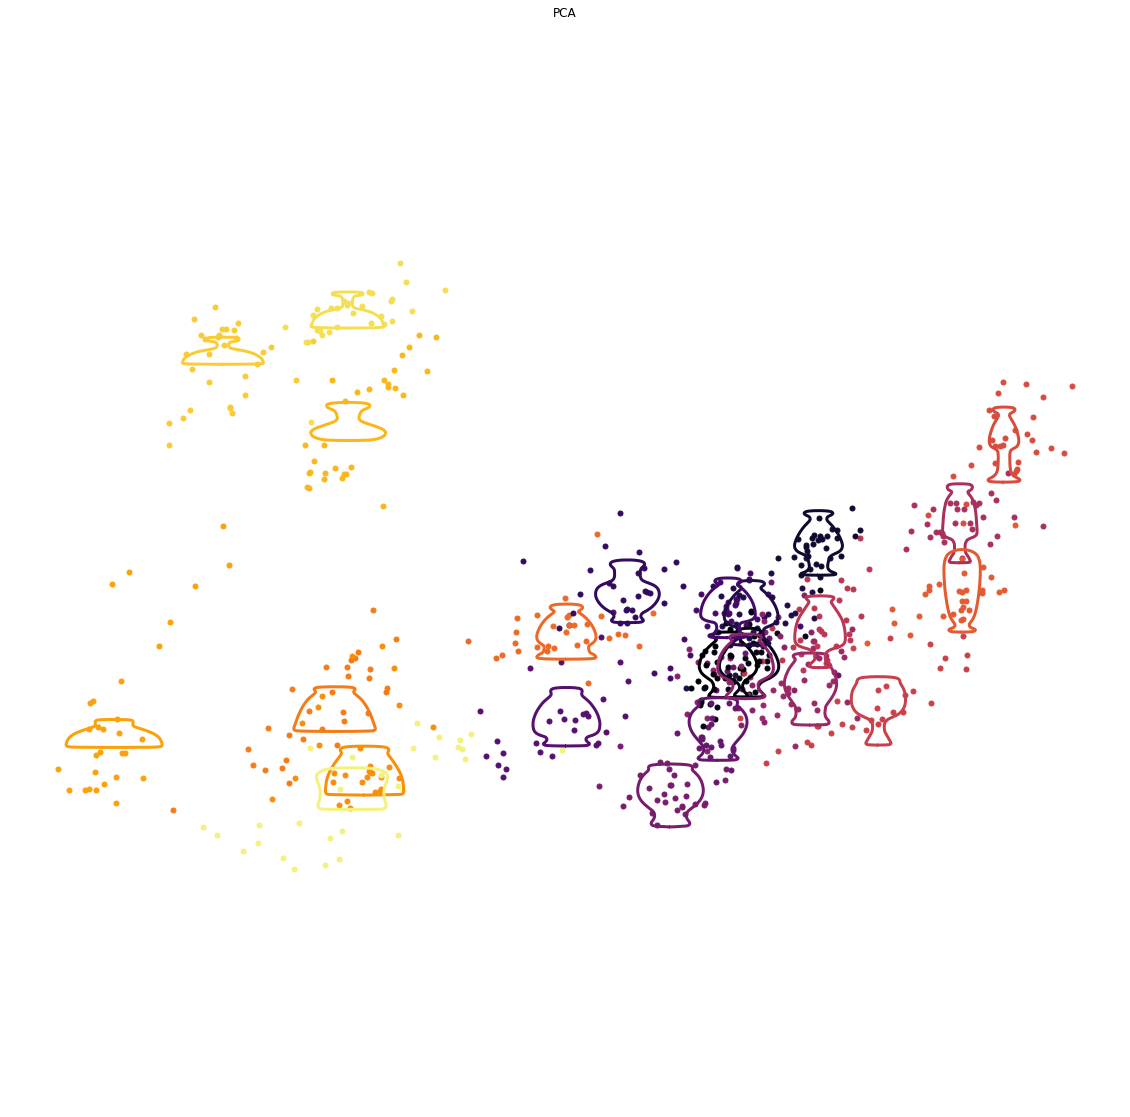

In [43]:
ndim = 2
m = np.mean(pots,axis=0)
b = np.zeros((npots,ndim))
for i in range(npots):
    P = evecs[:,:ndim]
    b[i,:] = np.dot(P.T,(pots[i,:]-m))

pots2 = pots.reshape(npots,npoints,2)
plotpca(b,pots,pots2[:,:,0],pots2[:,:,1],scaling=3)
pl.axis('equal')
pl.axis('off')
pl.title('PCA');
pl.savefig('Pots_PCA.pdf',dpi=600)

In [36]:
which = np.where(ind[:,1]==cl[0])
print(np.shape(pots))
print(np.shape(np.mean(pots[which,:],axis=1)))

(716, 276)
(1, 276)
